<a href="https://colab.research.google.com/github/Avadhesh-Kumar45/Research-Project/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.0


In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:50000,:]

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['May I sit here', 'Kann ich hier sitzen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #61514 (CK) & #804487 (Esperantostern)'],
       ['May I use that', 'Darf ich das benutzen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4642215 (CK) & #6645654 (Felixjp)'],
       ['May I use this', 'Darf ich das verwenden',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #549']],
      dtype='<U101')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

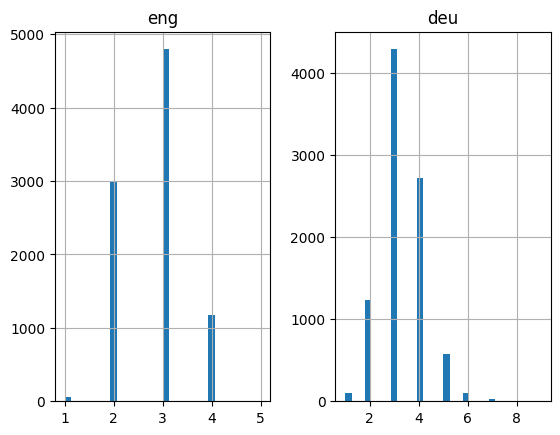

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2086


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 3416


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [ ]:
from tensorflow.keras import optimizers
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename = 'model.h1.24_jan_19.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 3.8860
Epoch 1: val_loss improved from inf to 2.63099, saving model to model.h1.24_jan_19.keras
12/12 [==============================] - 52s 4s/step - loss: 3.8860 - val_loss: 2.6310
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 2.3278
Epoch 2: val_loss improved from 2.63099 to 2.21734, saving model to model.h1.24_jan_19.keras
12/12 [==============================] - 42s 3s/step - loss: 2.3278 - val_loss: 2.2173
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 2.0995
Epoch 3: val_loss improved from 2.21734 to 2.09824, saving model to model.h1.24_jan_19.keras
12/12 [==============================] - 40s 3s/step - loss: 2.0995 - val_loss: 2.0982
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 2.0117
Epoch 4: val_loss improved from 2.09824 to 2.05064, saving model to model.h1.24_jan_19.keras
12/12 [==============================] - 39s 3s/step - loss: 2.0117 - v

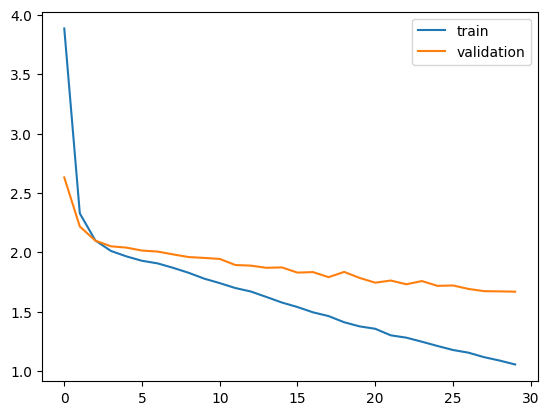

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
import numpy as np

# Load the model
model = load_model('model.h1.24_jan_19.keras')

# Make predictions
preds = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

# Convert probabilities to class labels
predicted_classes = np.argmax(preds, axis=1)


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
def get_word(n, tokenizer):
    # If n is an array, we need to handle this appropriately
    if isinstance(n, np.ndarray):
        n = np.argmax(n)  # Get the index of the highest probability class

    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None


In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,she was naive,we you me
1,he has no fear,he was sick
2,drop the gun,shes the flies
3,i dont study,i like to
4,it was a mouse,he was a dog
5,i trusted them,i said you
6,im unhappy,im i
7,tom relaxed,tom will
8,stay focused,go away
9,dont be upset,dont on it
